# Final Assignment

In this assignment, you will build a relation extraction model for scientific articles based on the [ScienceIE dataset](https://scienceie.github.io/) in a group of up to 3 students. This is the same dataset that was used for Assignment 2, where you had to train a model to extract keyphrases. You are welcome to build on code any team member already wrote for Assignment 2.

You will build and train relation extraction models on the ScienceIE dataset. For this, you will also need to do data preprocessing to convert the ScienceIE data into a format suitable for training a relation extraction models. 

Your mark will depend on:

* your **reasoning behind modelling choices** made
* the correct **implementations** of your relation extraction models, and
* the **performance** of your models on a held-out test set.

To develop your model you have access to:

* The data in `data/scienceie/`. Remember to un-tar the data.tar.gz file.
* Libraries on the [docker image](https://cloud.docker.com/repository/docker/bjerva/stat-nlp-book) which contains everything in [this image](https://github.com/jupyter/docker-stacks/tree/master/scipy-notebook), including scikit-learn, torch 1.2.0 and tensorflow 1.14.0. 


As with the previous assignment, since we have to run the notebooks of all students, and because writing efficient code is important, your notebook should run in 10 minutes at most, including package loading time, on your machine.
Furthermore, you are welcome to provide a saved version of your model with loading code. In this case loading, testing, and evaluation has to be done in 10 minutes. You can use the dev set to check if this is the case, and assume that it will be fine for the held-out test set if so.

## Setup Instructions
It is important that this file is placed in the **correct directory**. It will not run otherwise. The correct directory is

    DIRECTORY_OF_YOUR_BOOK/assignments/2019/final_assignment/problem/
    
where `DIRECTORY_OF_YOUR_BOOK` is a placeholder for the directory you downloaded the book to. After you placed it there, **rename the file** to your UCPH ID (of the form `xxxxxx`). 

## General Instructions
This notebook will be used by you to provide your solution, and by us to both assess your solution and enter your marks. It contains three types of sections:

1. **Setup** Sections: these sections set up code and resources for assessment. **Do not edit these**. 
2. **Assessment** Sections: these sections are used for both evaluating the output of your code, and for markers to enter their marks. **Do not edit these**. 
3. **Task** Sections: these sections require your solutions. They may contain stub code, and you are expected to edit this code. For free text answers simply edit the markdown field.  

Note that you are free to **create additional notebook cells** within a task section. 

**Do not share** this assignment publicly, by uploading it online, emailing it to friends etc. 

**Do not** copy code from the Web or from other students, this will count as plagiarism.

## Submission Instructions

To submit your solution:

* Make sure that your solution is fully contained in this notebook. 
* **Rename this notebook to your UCPH ID** (of the form "xxxxxx"), if you have not already done so.
* Download the notebook in Jupyter via *File -> Download as -> Notebook (.ipynb)*.
* Upload the notebook to Absalon.


## <font color='green'>Setup 1</font>: Load Libraries
This cell loads libraries important for evaluation and assessment of your model. **Do not change it.**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#! SETUP 1
import sys, os
_snlp_book_dir = "../../../../"
sys.path.append(_snlp_book_dir) 
import math
from glob import glob
from os.path import isfile, join
from statnlpbook.vocab import Vocab
from statnlpbook.scienceie import calculateMeasures
import shutil
import string

## <font color='blue'>Task 1</font>: Convert dataset between standoff and IOB format

We want to work with [the ScienceIE dataset](https://scienceie.github.io) that can be found in the `data/scienceie/` directory of the repository.  This dataset comes with **standoff annotation** for keyphrases and relations between them.  This means that for each document in the dataset, there are two files: a `.txt` file with the raw sentences, and a `.ann` file with the annotated keyphrases.  

For example, this is one of the `.txt` files from the training set:

```
Failure of structural components is a major concern in the nuclear power industry and represents not only a safety issue, but also a hazard to economic performance. Stress corrosion cracking (SCC), and especially intergranular stress corrosion cracking (IGSCC), have proved to be a significant potential cause of failures in the nuclear industry in materials such as Alloy 600 (74% Ni, 16% Cr and 8% Fe) and stainless steels, especially in Pressurised Water Reactors (PWR) [1–5]. Stress corrosion cracking in pressurized water reactors (PWSCC) occurs in Alloy 600 in safety critical components, such as steam generator tubes, heater sleeves, pressurized instrument penetrations and control rod drive mechanisms [2,6,7]. Understanding the mechanisms that control SCC in this alloy will allow for continued extensions of life in current plant as well as safer designs of future nuclear reactors.
```

And this is the corresponding `.ann` file:

```
T1	Material 11 32	structural components
T2	Process 0 32	Failure of structural components
T3	Process 254 259	IGSCC
T4	Process 213 252	intergranular stress corrosion cracking
*	Synonym-of T4 T3
T5	Process 165 190	Stress corrosion cracking
T6	Process 192 195	SCC
*	Synonym-of T5 T6
T7	Material 367 376	Alloy 600
T8	Material 378 402	74% Ni, 16% Cr and 8% Fe
*	Synonym-of T7 T8
T9	Material 408 424	stainless steels
T10	Material 440 466	Pressurised Water Reactors
T11	Material 468 471	PWR
T12	Process 480 505	Stress corrosion cracking
T13	Material 509 535	pressurized water reactors
T14	Material 537 542	PWSCC
*	Synonym-of T13 T14
T15	Material 554 563	Alloy 600
T16	Material 603 624	steam generator tubes
T17	Material 626 640	heater sleeves
T18	Material 642 677	pressurized instrument penetrations
T19	Material 682 710	control rod drive mechanisms
T20	Material 762 765	SCC
T21	Material 774 779	alloy
T22	Material 835 840	plant
T23	Task 852 892	safer designs of future nuclear reactors
T24	Material 876 892	nuclear reactors
T25	Material 567 593	safety critical components
R1	Hyponym-of Arg1:T16 Arg2:T25	
R2	Hyponym-of Arg1:T17 Arg2:T25	
R3	Hyponym-of Arg1:T18 Arg2:T25	
R4	Hyponym-of Arg1:T19 Arg2:T25
```

Note: Besides keyphrases, which you are already familiar with from Assignment 2, the `.ann` files also contain relation annotations labeled `Hyponym-of` and `Synonym-of`. These are relations between keyphrases. 

`Synonym-of` is an undirected relation, meaning that if you see a line like this:

```*	Synonym-of T13 T14```

The order of keyphrases could be swapped, i.e. the following would also hold:

```*	Synonym-of T14 T13```

The evaluation script will thus be agnostic to the order in which the keyphrases between which `Synonym-of` relations hold are ordered.

`Hyponym-of`, on the other hand, is a directed relation, meaning that it is order-sensitive, and that the evaluation script will take the order of keyphrases between which `Hyponym-of` relations hold into account.

The `.ann` standoff format is **documented in [the brat documentation](http://brat.nlplab.org/standoff.html).**  
You may want to convert the format into some internal representation for training models; however, how you do that is up to you, i.e. you do not have to use IOB format like in Assignment 2. 

**Further Notes**:
- At training time, you you will be provided with plain text documents and `.ann` files with keyphrases and relations
- At test time, you will be provided with plain text documents and `.ann` files **with keyphrases only**. This is because your task is to predict relations.
- The evaluation script is agnostic to the order of relation triples and relation ids, but should preserve the ids of the keyphrases that will be used in the predicted relations. The evaluation scripts requres the entity annotations to be present as well in the prediction file.

### Module imports

To highlight the important parts of the assignmen, most of the functions are written in modules in 'Extra_files/modules'. These are imported below.

In [3]:
### General modules
import pprint
from gensim.models import fasttext
from gensim.models import KeyedVectors
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pp = pprint.PrettyPrinter(compact = True).pprint

### Our own modules
from Extra_files.modules.load_and_save import load_scienceie, save_to_ann, reformat_to_save
from Extra_files.modules.rules import _add_rules
from Extra_files.modules.error_analysis import plot_confusion_matrix, get_dataframe, plot_correct_labels
from Extra_files.modules.DataPreparation import entityLocator, addPOStoDic, addLemmatoDic, inputPair
from Extra_files.modules.WordEmbedder import WordEmbedder
from Extra_files.modules.MasterVocab import MasterVocab
from Extra_files.modules.scaling import downscale, upscale
from Extra_files.models.dummy_model import _sebastians_dummy_model

### Load Sciencie

The 'load_scienceie' converts the dataset from standoff to IOB format.<br>
Due to overlapping sentences, some of the entities must be removed, and this also results in loss of relations. The exact numbers are printed. 

After having converted it to IOB-format, it removes references ([13],[14-16], etc.). These are defined as brackets with only integers, or the symbols '-', '-' or komma in.

It also concatenates 'i.e.' and 'e.g.' to a single words. These are extensively used between hyponyms, and it is believed that it will be easier for the CNN implemented below to detect the importance of 'i.e.' than 'i', '.', 'e', '.'.

In [4]:
print("Loading dev_data...")
dev_data = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "dev"))
print("Loading train_data...")
train_data = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))

Loading dev_data...
Number of entities removed due to overlap: 269 out of 1330
Number of entities not identified in text: 1 out of 1061
Number of relations lost due to overlap: 10 out of 168
Removed references.
Concatenated 'i.e.' and 'e.g.'.
Loading train_data...
Number of entities removed due to overlap: 1337 out of 7405
Number of entities not identified in text: 28 out of 6068
Number of relations lost due to overlap: 50 out of 673
Removed references.
Concatenated 'i.e.' and 'e.g.'.


### Generate Vocab classes for transformation to indices

### Spacy

We will use Spacy's model 'en' for POS-tagging and lemmatizations later. This therefore has to be downloaded:

In [5]:
!python -m spacy download en
import spacy
nlp = spacy.load("en")
nlp.tokenizer = nlp.tokenizer.tokens_from_list

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.6/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
from pickle import load, dump

# Generate the Vocab classes

vocab = MasterVocab(max_vocab_size = 80092) # Figure out which size we want
vocab.generateVocabularies(train_data, nlp)
# dump(vocab, open('Extra_files/resources/vocab.pkl', 'wb'))

#vocab = load(open('Extra_files/resources/vocab.pkl', 'rb'))


### Build FastText embedding with limits

In [7]:
# Here we build the FastText model
if False:
    engbedder = WordEmbedder()
    engbedder.buildModel_viaVocab(vocab, limit_ours = 15000, limit_large = 350000)

Model built. Added a total of counter 3211 words to our vocab from larger model
MasterVocab size: 8467, MasterVocab words in our FastText Vocab 7527, coverage: 0.8889807487894177


### PCA for FastText embeddings

In [8]:
engbedder = WordEmbedder()
engbedder.loadModel()

#words = [vocab.word_vocab.get_label(i) for i in range(len(vocab.word_vocab))]
#print(len(words))
#engbedder.fitPCA(words, 50)
engbedder.fitPCA_viaVocab(vocab, 50)
print(engbedder.pcaModel.explained_variance_ratio_)
#engbedder.savePCA("pcatest.pkl")
#engbedder.savePCA()
#engbedder.loadPCA()
#engbedder.getEmbedding("Walk")

[0.06168888 0.03941803 0.02972612 0.02145819 0.01790349 0.01664172
 0.01501379 0.01202332 0.01147084 0.01110061 0.01068856 0.01004918
 0.0096548  0.00939651 0.00920155 0.00867658 0.00829394 0.00766225
 0.00759482 0.00712849 0.00704564 0.00675751 0.0065974  0.00650633
 0.0064114  0.00621904 0.00603532 0.0058803  0.00578348 0.00575093
 0.00570174 0.00561655 0.00548467 0.00541773 0.00530178 0.00508766
 0.00497124 0.00489233 0.00478426 0.00461315 0.00451336 0.00447697
 0.00444355 0.00433286 0.00431829 0.00428551 0.00420909 0.00411794
 0.00408244 0.00402445]


[0.06168888 0.03941803 0.02972612 0.0214582  0.0179035  0.01664175
 0.01501382 0.01202366 0.01147124 0.01110102 0.01068968 0.01005117
 0.00965578 0.00939921 0.00920357 0.00867995 0.00829917 0.00767803
 0.00760312 0.00714695 0.0070558  0.00677208 0.00662882 0.00652648
 0.00644539 0.00626252 0.00606656 0.00594213 0.00585703 0.00579109]


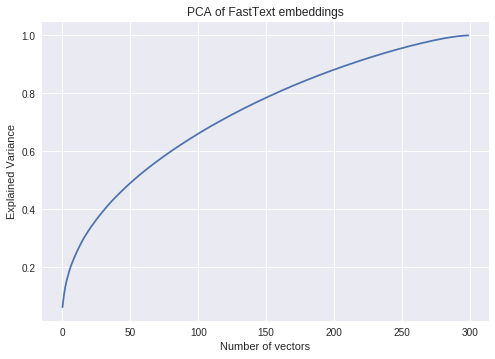

In [9]:
# PCA PLOT
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = [vocab.word_vocab.get_label(i) for i in range(len(vocab.word_vocab)) if vocab.word_vocab.get_label(i) in engbedder.vmodel.vocab] # set range 2,len to avoid pad/unk
embeddings = [engbedder.getEmbedding_prePCA(word, indicator = False) for word in words]

pca = PCA(n_components=300)
pca.fit(embeddings)
print(pca.explained_variance_ratio_[:30])
evar = np.cumsum(pca.explained_variance_ratio_)

plt.plot(evar)
plt.title("PCA of FastText embeddings")
plt.ylabel("Explained Variance")
plt.xlabel("Number of vectors")
plt.show()